#### Simulating the travelling salesman problem with three cities.

* Importing important libraries

In [5]:
from qiskit import *
from qiskit.circuit import parameter
from qiskit.circuit import ParameterVector, Parameter
from qiskit.visualization import plot_histogram
from IPython.core.display import Latex
from qiskit_algorithms.optimizers import ADAM, COBYLA
from qiskit_algorithms.gradients import SPSAEstimatorGradient
from qiskit_aer import AerSimulator, StatevectorSimulator
import numpy as np
import ot
import re
from qiskit.circuit.library.standard_gates import RXGate, RYGate, RZGate, RZZGate

* Cost Matrix

In [6]:
# TSP- 3

K = np.array([[0.        ,0.81721768, 0.55177632],
 [0.81721768, 0.        , 0.6720918 ],
 [0.55177632, 0.6720918 , 0.        ]])



In [7]:
n = 3
beta_para = 1.39957953
theta1 = [1.9026521]
theta2 = [2.22944427]
alpha = [5.56530919]

* Parameters

In [4]:
# n = 3    # Number of cities
# beta_para = (2 * np.pi * np.random.rand(1))[0]         # Beta parameters
# theta1 = (2 * np.pi * np.random.rand(1))        # Perceptron layers 1st parameters
# theta2 =(2 * np.pi * np.random.rand(1))   # Perceptron layers 2nd parameters
# alpha = (2 * np.pi * np.random.rand(1))       # Alpha parameters for pooling layer

# # initial_point = np.array([beta_para for i in range(n*n)]+[theta1[0] for i in range(n*n)]+
# #                          [theta2[0] for i in range(n*n)]+[alpha[0] for i in range(n*n)])


In [8]:
class TSP_Solver:
    def __init__(self, reference_circuit, variational_circuit,MCRX, n, K, theta1, theta2, alpha, matching_matrix, loss):
        self.ref_cir = reference_circuit
        self.var_cir = variational_circuit
        self.MCRX = MCRX
        self.n = n
        self.n1 = n*n  # Squared of number of cities
        self.a_m = K   # a_m
        self.alpha = alpha
        self.theta1 = theta1
        self.theta2 = theta2
        self.matching_matrix = matching_matrix  # A constraint matrix for matching with the ground truth
        self.loss = loss
    
    "Creating an object of encoding layer"
    def encoding_layer(self):
#         for q in range(len(self.K)):
#             self.ref_cir.ry(self.K[q], q)
#         self.ref_cir.barrier()
        ry = []
        for i in range(len(self.a_m[0])):
            ry.append(RYGate(self.a_m[i][i]))
            
#         self.ref_cir.append(ry[0], [0])  # a_m = adjacency matrix
#         self.ref_cir.append(ry[1], [4])
#         self.ref_cir.append(ry[2], [8])

        rzz = []
        for i in range(len(self.a_m[0])):
            for j in range(len(self.a_m[1])):
                if i != j:
                    rzz.append(RZZGate(self.a_m[i][j]))

        self.ref_cir.append(rzz[0], [0, 1])
        self.ref_cir.append(rzz[1], [0, 2])

        self.ref_cir.append(rzz[2], [3, 4])
        self.ref_cir.append(rzz[3], [3, 5])

        self.ref_cir.append(rzz[4], [6, 7])
        self.ref_cir.append(rzz[5], [6, 8])
        self.ref_cir.barrier()
    
    'Function that return the ctrl qubits for constrained layer'
    def ctrl_qubits(self, matrix, row_idx, col_idx):
        neighbors = []
        num_rows = len(matrix)
        num_cols = len(matrix[0])

        # Add neighbors from the same row
        for j in range(num_cols):
            if j != col_idx:  # Exclude the element itself
                neighbors.append(matrix[row_idx][j])

        # Add neighbors from the same column
        for i in range(num_rows):
            if i != row_idx:  # Exclude the element itself
                neighbors.append(matrix[i][col_idx])

        return neighbors
            
    "Defining contraint layer"
    def constraint_layer(self): 
        matrix = np.array([i for i in range(self.n*self.n)]).reshape(self.n, self.n)
        for i in range(self.n):
            for j in range(self.n):  
                ctrl = list(self.ctrl_qubits(matrix, i, j))+[matrix[i][j]]
                self.var_cir.append(self.MCRX, ctrl)    
        self.var_cir.barrier()
    
    "Perceptron layer"
    def perceptron_layer(self):
        rz = RZGate(self.theta1[0])
        ry = RYGate(self.theta2[0])
        for q in range(self.n1):
            self.var_cir.append(rz, [q])
            self.var_cir.append(ry, [q])
        self.var_cir.barrier()
               
    'Pooling Layer'
    def pooling_layer(self):
        ry = RYGate(self.alpha[0])
        for q in range(self.n1):
            self.var_cir.append(ry, [q])
    
    'composing the reference and variational circuits'
    # The circuit can be visualized as well from here.
    def ansatz(self):
        ansat = self.ref_cir.compose(self.var_cir)
        ansat.measure_all()
        return ansat
    
    'Statvector simulating'
    def statevect(self):
        simulator = Aer.get_backend('statevector_simulator')
        result = execute(self.ansatz(), simulator).result()
        statevector = result.get_statevector()
        return statevector.draw('latex')
    
    def sinkhorn_normalization(self, matrix, epsilon=1e-3, max_iters=100, constraint_epsilon=1e-9):
        assert matrix.shape[0] == matrix.shape[1], "Input matrix must be square"

        # Get the shape of the matrix
        n = matrix.shape[0]

        # Initialize u and v vectors
        u = np.ones(n)
        v = np.ones(n)

        # Perform Sinkhorn iterations
        for _ in range(max_iters):
            u_new = 1 / (np.dot(matrix, v) + epsilon)
            v_new = 1 / (np.dot(matrix.T, u_new) + epsilon)

            # Check convergence
            if np.allclose(u_new, u) and np.allclose(v_new, v):
                break

            u = u_new
            v = v_new

        # Compute the Sinkhorn normalized matrix
        normalized_matrix = np.diag(u_new) @ matrix @ np.diag(v_new)

        # Apply constraint on zero terms
        normalized_matrix[normalized_matrix < constraint_epsilon] = constraint_epsilon

        # Renormalize the matrix to ensure it remains doubly stochastic
        row_sums = np.sum(normalized_matrix, axis=1)
        col_sums = np.sum(normalized_matrix, axis=0)
        normalized_matrix /= np.sqrt(np.outer(row_sums, col_sums))

        return normalized_matrix

    'Reshaping result to matrix'
    def x_matrix(self):
        latex_string = self.statevect().data     # Stores the statevector as a latex string5
        latex_list = list(latex_string)        # This object stores the statevector as a list
        
        'Extracting only the states of the qubits'
        a = latex_list.index('|')
        b = latex_list.index('\\')
        y = latex_list[a+1:b]
        y1 = np.array([int(i) for i in y])
        Y1 = y1.reshape(self.n, self.n)  # Reshaping the measured states of qubits to a matrix 

        # Apply Sinkhorn algorithm to converge to a doubly stochastic matrix with the matching constraint
        X_ds = self.sinkhorn_normalization(Y1)
        return X_ds
    
    def cost_fun(self):
        """Cost function of circuit parameters on training data.
            The optimizer will attempt to minimize this."""
        X = list(self.matching_matrix.flatten())
        Y = list(self.x_matrix().flatten())
        for i in range(len(X)):
            self.loss += (-X[i]*np.log(Y[i]) + (1-X[i])*np.log(1-Y[i]))
        return self.loss


#### Calling the whole class here
* Number of Cities 'n'
* Quantum circuit 
* Applying Hadammard to all qubits

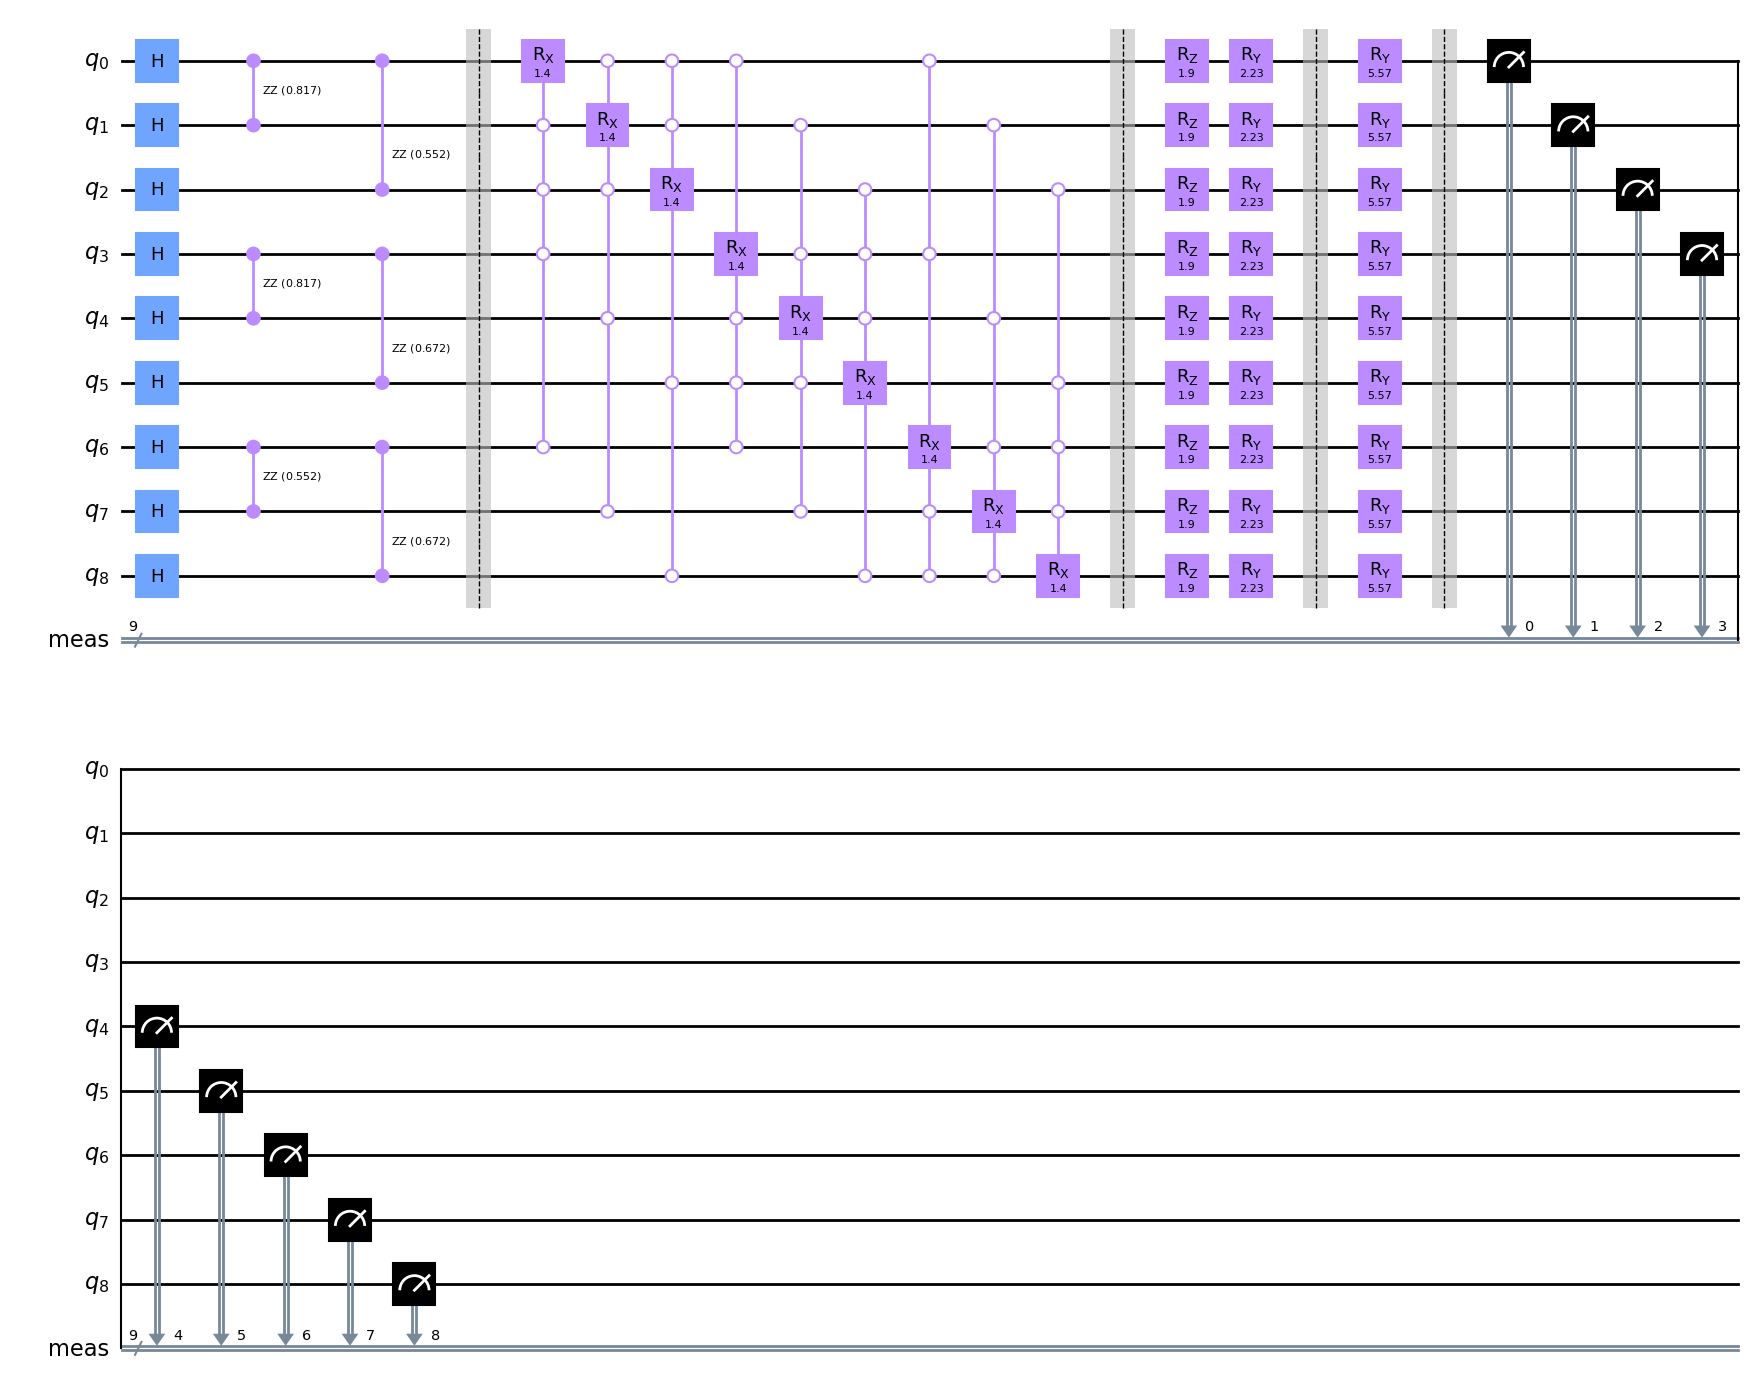

In [9]:
def call_pass_obj_fun(TSP):
    TSP.encoding_layer()
    TSP.constraint_layer()
    TSP.perceptron_layer()
    TSP.pooling_layer()
#     TSP.ansatz()
    
    return TSP.ansatz().draw('mpl')
#     TSP.statevect()
#     return TSP.x_matrix()
#     TSP.cost_fun()
#     return TSP.loss
m_c = np.array([[1, 0,]])

reference_circuit = QuantumCircuit(n*n)      # Circuit to which data be encoded
reference_circuit.h([i for i in range(n*n)])
variational_circuit = QuantumCircuit(n*n)     # Circuit for

loss = 0
MCRX=RXGate(beta_para).control(4, ctrl_state='0000')

TSP = TSP_Solver(reference_circuit, variational_circuit, MCRX, n, K, theta1, theta2, alpha, m_c, loss)
call_pass_obj_fun(TSP)

##### Objective function for optimizer

In [36]:
def objective_function(params):

    theta1_values = params[9:18]  # Extract first 9 values for theta1
    theta2_values = params[18:27]  # Extract next 9 values for theta2
    alpha = params[27:36]  # Extract alpha
    beta_para = params[:1]  # Extract beta_para

    # Set theta1 and theta2 values
    TSP.theta1 = theta1_values
    TSP.theta2 = theta2_values
    TSP.alpha = alpha

    # Update the beta_para for MCRX gate
    beta_angle = beta_para[0]  # Assuming you want to use the first value from beta_para
    MCRX = RXGate(beta_angle).control(4, ctrl_state='0000')
    TSP.MCRX = MCRX
    
    # Run the quantum neural network and compute loss
    obj_loss = call_pass_obj_fun(TSP)
    return obj_loss

##### Gradient for the optimizer


In [37]:
def gradient_function(params):

    epsilon = 1e-6  # pert value

    initial_loss = objective_function(params)

    params_plus = params.copy() + 2*epsilon
    
    loss_plus = objective_function(params_plus)
    
    gradient = (loss_plus - initial_loss) / 2*epsilon

    return gradient

In [38]:

initial_point = np.array([beta_para for i in range(n*n)]+[theta1[0] for i in range(n*n)]+
                         [theta2[0] for i in range(n*n)]+[alpha[0] for i in range(n*n)])

# Instantiate Adam optimizer
adam_optimizer = ADAM(maxiter= 5, tol=1e-06, lr=0.1, beta_1=0.9,
                      beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=False, snapshot_dir=None)

# Run optimization
result = adam_optimizer.minimize(objective_function, initial_point, gradient_function)
result.x

array([1.39957953, 1.39957953, 1.39957953, 1.39957953, 1.39957953,
       1.39957953, 1.39957953, 1.39957953, 1.39957953, 1.9026521 ,
       1.9026521 , 1.9026521 , 1.9026521 , 1.9026521 , 1.9026521 ,
       1.9026521 , 1.9026521 , 1.9026521 , 2.22944427, 2.22944427,
       2.22944427, 2.22944427, 2.22944427, 2.22944427, 2.22944427,
       2.22944427, 2.22944427, 5.56530919, 5.56530919, 5.56530919,
       5.56530919, 5.56530919, 5.56530919, 5.56530919, 5.56530919,
       5.56530919])

In [15]:
!git pull origin main

Merge made by the 'ort' strategy.
 TSP Data.xlsx | Bin 0 -> 336772 bytes
 TSP-5.xlsx    | Bin 0 -> 338247 bytes
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 TSP Data.xlsx
 create mode 100644 TSP-5.xlsx


From https://github.com/Sajjad-Ahmad-phy/Final-Year-Project
 * branch            main       -> FETCH_HEAD
   9d798e7..e6d67f6  main       -> origin/main


###### A main function from where the whole class or TSP-Simulation be controlled

In [1]:
!git add .
!git commit -m "Your commit message"

[main cef3a32] Your commit message
 10 files changed, 1227 insertions(+), 3326 deletions(-)
 delete mode 100644 .ipynb_checkpoints/TSP_simulation_classically-checkpoint.ipynb
 create mode 100644 .ipynb_checkpoints/TSP_with_Brute_Force-checkpoint.ipynb
 delete mode 100644 .ipynb_checkpoints/Training TSP-Solver-checkpoint.ipynb
 delete mode 100644 .ipynb_checkpoints/Untitled-checkpoint.ipynb
 delete mode 100644 TSP_simulation_classically.ipynb
 create mode 100644 TSP_with_Brute_Force.ipynb
 delete mode 100644 Training TSP-Solver.ipynb
 delete mode 100644 Untitled.ipynb


In [2]:
!git push -u origin main

branch 'main' set up to track 'origin/main'.


To https://github.com/Sajjad-Ahmad-phy/Final-Year-Project.git
   bfe09f3..cef3a32  main -> main
